# SNN performance analysis with histogram and roc curve

It is not possible to calculate an accuracy for the SNN alone, since it is not a classifier. Instead, we used distance histograms and ROC curves to evaluate SNN performance. The greater the separability between the distance densities and the greater the area under the ROC curve, the better the SNN.

## Code

The next 8 cells are the same as the cells shown in the training notebook, with the only difference being that the SNN weights are loaded from a file rather than fitted.

To run this notebook on Google Colab, you will need to upload files:

* helper.py
* pairing.py
* partitioning.py
* snn.py 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from snn import SNN
import helper

In [2]:
helper.download_celeba()

Found celeba Data
done


In [3]:
from partitioning import build_celeba_partitions
build_celeba_partitions()

Generating partitions (EVAL=1/4, TRAIN=3/4)
Partitions file already generated


In [4]:
from pairing import build_celeba_pairs
build_celeba_pairs()

EVAL
Already generated
TRAINING
Already generated


In [5]:
def load_images(paths):
    images = [helper.get_image(path, 80, 80, 'RGB').astype(np.float)/255 for path in paths]
    return np.array(images)

In [6]:
eval_genuine_pairs = pd.read_csv(os.path.join('celeba_pairs', 'eval_genuine_pairs.csv'))
eval_impostor_pairs = pd.read_csv(os.path.join('celeba_pairs', 'eval_impostor_pairs.csv'))

In [7]:
def build_resnet50_encoder(n_features=100):
    base_model = ResNet50(weights=None, include_top=False, input_shape=(80,80,3))
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.7)(x)
    x = layers.Dense(n_features, activation='linear')(x)
    model = keras.Model(inputs = base_model.input, outputs = x)
    return model

In [8]:
my_snn = SNN((80,80,3),build_resnet50_encoder())
my_snn.load_encoder('resnet50_encoder_weights.h5')

2022-02-12 03:59:00.151246: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-12 03:59:00.151722: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-12 03:59:00.154231: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In the next cell, the X and Y functions are intended to generate the genuine and imposter image pairs.

In [9]:
def get_genuine_pairs(n_pairs=1000):
    assert eval_genuine_pairs.shape[0] >= n_pairs
    my_rows = eval_genuine_pairs.sample(n=n_pairs)
    images_a = load_images([os.path.join('celeba', 'img_align_celeba', fn) for fn in list(my_rows['file_a'])])
    images_b = load_images([os.path.join('celeba', 'img_align_celeba', fn) for fn in list(my_rows['file_b'])])
    return [images_a, images_b]

def get_impostor_pairs(n_pairs=1000):
    assert eval_impostor_pairs.shape[0] >= n_pairs
    my_rows = eval_impostor_pairs.sample(n=n_pairs)
    images_a = load_images([os.path.join('celeba', 'img_align_celeba', fn) for fn in list(my_rows['file_a'])])
    images_b = load_images([os.path.join('celeba', 'img_align_celeba', fn) for fn in list(my_rows['file_b'])])
    return [images_a, images_b]

In the next cell, the distances will be taken from the trained SNN.

In [10]:
genuine_pairs = get_genuine_pairs()
impostor_pairs = get_impostor_pairs()

distances_genuines = my_snn.keras_model.predict(genuine_pairs)
distances_impostors = my_snn.keras_model.predict(impostor_pairs)

2022-02-12 04:00:05.355319: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-12 04:00:05.477884: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1596235000 Hz


In the next cell, the distance densities will be plotted in histograms. Note that the more separate the distance distribution of the genuine pairs is from the distance distribution of the imposter pairs, the better the SNN.

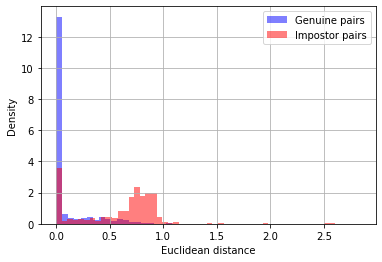

In [13]:
ng, bg, pg = plt.hist(distances_genuines, bins=50, color='blue', alpha=0.5, label='Genuine pairs', density=True)
ni, bi, pi = plt.hist(distances_impostors, bins=50, color='red', alpha=0.5, label='Impostor pairs', density=True)
plt.xlabel('Euclidean distance')
plt.ylabel('Density')  
plt.legend()
plt.grid()
plt.show()

The next two cells are for the purpose of plotting an ROC curve. The larger the area under the curve, the better.

In [16]:
def plot_roc(x, good_pdf, bad_pdf, ax):
    '''
    Source: https://towardsdatascience.com/receiver-operating-characteristic-curves-demystified-in-python-bd531a4364d0
    '''
    #Total
    total_bad = np.sum(bad_pdf)
    total_good = np.sum(good_pdf)
    #Cumulative sum
    cum_TP = 0
    cum_FP = 0
    #TPR and FPR list initialization
    TPR_list=[]
    FPR_list=[]
    #Iteratre through all values of x
    for i in range(len(x)):
        #We are only interested in non-zero values of bad
        if bad_pdf[i]>0:
            cum_TP+=bad_pdf[len(x)-1-i]
            cum_FP+=good_pdf[len(x)-1-i]
        FPR=cum_FP/total_good
        TPR=cum_TP/total_bad
        TPR_list.append(TPR)
        FPR_list.append(FPR)
    #Calculating AUC, taking the 100 timesteps into account
    auc=np.sum(TPR_list)/100
    #Plotting final ROC curve
    ax.plot(FPR_list, TPR_list)
    ax.plot(x,x, "--")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title("ROC Curve", fontsize=14)
    ax.set_ylabel('TPR', fontsize=12)
    ax.set_xlabel('FPR', fontsize=12)
    ax.grid()
    ax.legend(["AUC=%.3f"%auc])

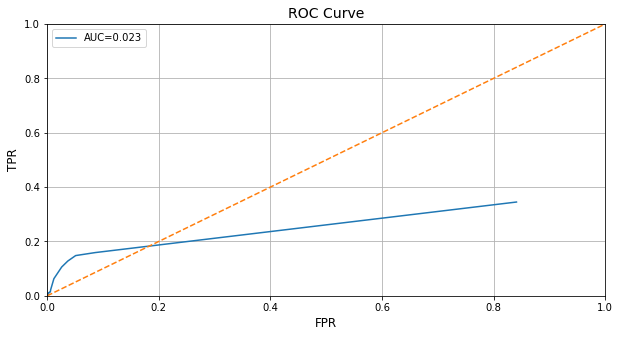

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_roc(np.arange(ng.shape[0]), ng, ni, ax)